# Installation

In [1]:
import os
import time
import functools

import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as display

# Custom Dataset

In [2]:
people = tfds.load("faces")["train"].take(500)
clouds = tfds.load("clouds")["train"].take(500)

2022-02-27 17:33:13.127735: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Constants

In [3]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [4]:
def preprocess_image(image):
    image = image["image"]
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image[tf.newaxis, :]
    return image

In [5]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

In [6]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [7]:
people = people.map(preprocess_image)
clouds = clouds.map(preprocess_image)

In [8]:
content_image = next(iter(people))
style_image = next(iter(clouds))

2022-02-27 17:33:13.310139: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-02-27 17:33:13.353141: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


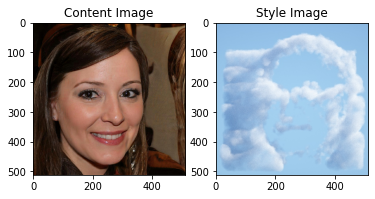

In [9]:
plt.subplot(1, 2, 1)
imshow(content_image, "Content Image")
plt.subplot(1, 2, 2)
imshow(style_image, "Style Image")

# Model Setup

In [10]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights="imagenet")
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [11]:
content_layers = ["block5_conv2"] 
style_layers = ["block1_conv1", "block2_conv1", "block3_conv1",  "block4_conv1", "block5_conv1"]

In [12]:
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [13]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image * 255)

## Calculate Style

In [14]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum("bijc,bijd->bcd", input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

## Extract Style

In [15]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
    
    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}
        return {"content": content_dict, "style": style_dict}

In [16]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

In [17]:
style_targets = extractor(style_image)["style"]
content_targets = extractor(content_image)["content"]

# Train Model

In [18]:
image = tf.Variable(content_image)

In [19]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [20]:
total_variation_weight = 30

In [21]:
style_weight = 1e-2
content_weight = 1e4

In [22]:
def style_content_loss(outputs):
    style_outputs = outputs["style"]
    content_outputs = outputs["content"]
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [25]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight * tf.image.total_variation(image)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

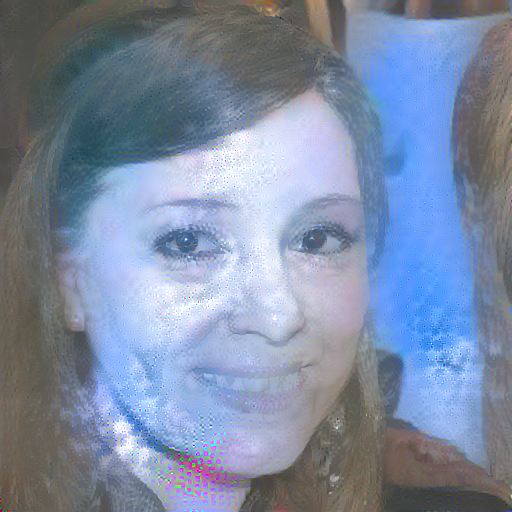

Train Step: 2000
Total Time: 4422.8


In [26]:
start = time.time()
epochs = 20
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end="", flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train Step: {}".format(step))

end = time.time()
print("Total Time: {:.1f}".format(end - start))